### Board-Interlocking and Corporate Governance on Company Performance and Innovation 

Name: Bingfeng Hu
CID: 01137798 
Date: 14/06/24


In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore
import text_analysis as ta
import graph_analysis as ga
import regression_analysis as ra
import stata_setup
stata_setup.config("/usr/local/stata18", "se", splash=False)
from pystata import stata

### 1. Introduction and Context

This report seeks to fill crucial theoretical and methodological gaps in understanding the factors driving innovation and performance in the biopharmaceutical sector. In this notebook, I will focus on intial EDA that will help with   further research in understanding the key drivers of company performance and innovation, based on corporate decision making and board composition. In particular, my research will focus on  bio-pharmaceutical sectors in the US. This initial investigation will focus on two specific elements may significantly company performance and innovation: board interlocks and risk orientation, alongside the sentiment derived from firm annual reports.

The empirical setting  focuses on all publicly listed US biotechnology and pharmaceutical firms from 2014 to 2024 in order to understand recent trends and shifts in the industry. For this preliminary analysis, we specifically focus on the most recent data from 2021 to 2024 to capture the latest dynamics. Specifically, I will focus my analysis on using 3 different data sources from Whartons Research Data Services (WRDS). These include Boardex (focussing on Board Interlocking), SEC 10-K annual reports (text analysis on topic modelling and sentiment), and financial metrics (given by Compustat). For sampling all  the US biopharmaceutical companies, I use the following industry codes given by CIK with values '8731', '8733', '2833', '2834', '2835', '2836'. After removing duplicates and linking the data we have against all 3 sources, I will perform analysis on over 600 companies for 2022 and 2023. By employing, graph theory and natural language processing using topic modelling with Bayesian methods (with LDA), I will present details in the various sections below.

### 2. Graph structure analysis for graph interlocking

In this section, we will look at the board-interlocking structure of directors. Information regarding board interlocks was sourced from the Boardex database. This includes details on board members' affiliations and their roles across different firms, which helps in mapping the network of corporate governance and its potential influence on firm strategies and performance, with data available from 2022 to 2024. 

In particular, the data below is composed of directors given by `boardid` and `directorid` (both ids represent directors) who sit on the same board. However, for the board interlock below, I want to look at stronger connections between directors in terms of the bridging effect of directors on companies. In other words, we form edges between directors if these directors simultaneously sit on two different companies at the same time. This will allow us to look at stronger social connections which bind companies together, and therefore stronger cooperation between companies, and therefore stronger and effective information sharing, and interlocking decision patterns between them, which can significantly affect company performance.

In [2]:
YEARS = [2022, 2023, 2024] # set years for boardex

In [3]:
file_path = "raw_data/boardex_us_companies_full_data_2022_2024.csv"
filtered_data_df, boardex_data = ga.get_filtered_graph_data(file_path)
filtered_data_df.head(2)

,boardid,companyid,directorid,overlapyearstart,overlapyearend
0,401.0,2734400.0,601453.0,2020,NaN
1,401.0,3700766.0,601453.0,2023,NaN


In [4]:
filtered_data_df.boardid.drop_duplicates().shape, filtered_data_df.directorid.drop_duplicates().shape

((749,), (10188,))

##### a. Data Linking

Here we link the Boardex data to the Boardex-Compustat id link table to get the common company id `gvkey`, which we can then use to link with other data sources for Compustat, and the annual reports from the SEC

In [5]:
boardex_gvkey_df = pd.read_csv("raw_data/USE_THIS_GVKEY_boardex_us_companies_keys.csv",
                               index_col= 0)

##### b. Create the graphs by year

Next we create a graph adjacency matrix with the bridging effect described previously for each year we have in the Boardex data as a dictionary by year and corresponding adjacency matrix as the value.

In [6]:
boardex_interlock_adj_dict = ga.create_adjacency_matrices_by_year(filtered_data_df, YEARS)

In [7]:
[x.shape for x in boardex_interlock_adj_dict.values()]

[(1694, 1694), (1059, 1059), (280, 280)]

Here we see that, if we model the connectivity in terms of directors bridging effect, i.e. an edge when there are directors who simultaneously sit on two different companies. We see that the directors who have such relationships of this strong connectivity are 1694, 1059 and 280 for 2022, 2023, and 2024 respectively. We see that there are only 280 directors, this shows that 2024 data is relatively incomplete compared to the other 2 years of study. This makes sense since 2024 is not over yet.

##### c. Link the graph statistics back to the relevant companies


Now we look at the graph statistics of the created graph by year.

In [8]:
graph_stat_df_final = ga.create_graph_statistics_df_by_year(boardex_interlock_adj_dict, YEARS)

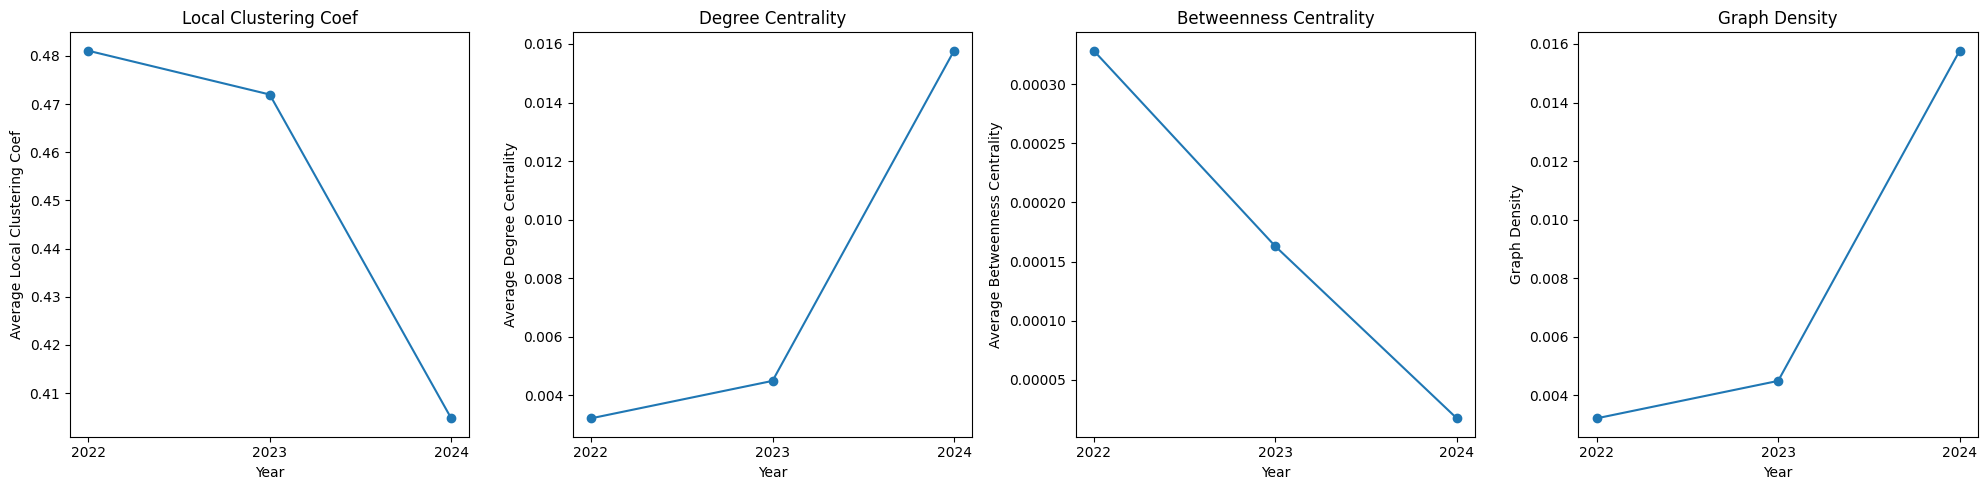

In [9]:
ga.plot_network_statistics(graph_stat_df_final)

Here, we can see that in terms of the average graph statistics for connectivity, we see that in terms of connectivity and local clustering, the graph in 2022 and 2023 are less connected and sparser compared to 2024. This is consistent with the comparison of the graph’s density; we can see that graph in 2024 is much more connected compared to the graph in 2022 than 2023 due to this data’s incompleteness. As part of the analysis, we will drop 2024 as part of the overall regression analysis.

In the below, we use the graph statistics created above at the director level and create company level statistics instead to look at the social impact of board interlocking on each company as a whole. This is done by averaging these director level node statistics, `local_clustering_coef`,`degree_centrality` and `betweenness_centrality` by company and year.

In [10]:
boardex_graph_stats_df = ga.create_company_level_statistics(boardex_data, boardex_gvkey_df, graph_stat_df_final)
boardex_graph_stats_df["companyid"].drop_duplicates().shape

(615,)

Here, we see that there are 615 companies overall for our analysis to analyse for the Boardex data over the course of 3 years (2022, 2023, and 2024). Next we visualise the graph data structure of these graphs over time. We can see that these graphs are consistent with the graph statistics we saw before. We see that the graph in 2024 has much fewer nodes compared to those in 2022 and 2023. Moreover, we see that the graphs in 2022 and 2023 have a more centralised community of directors linking companies together, compared to 2024 which has a more localised set of communities of companies connected by directors, who simulataneously sit on these boards.

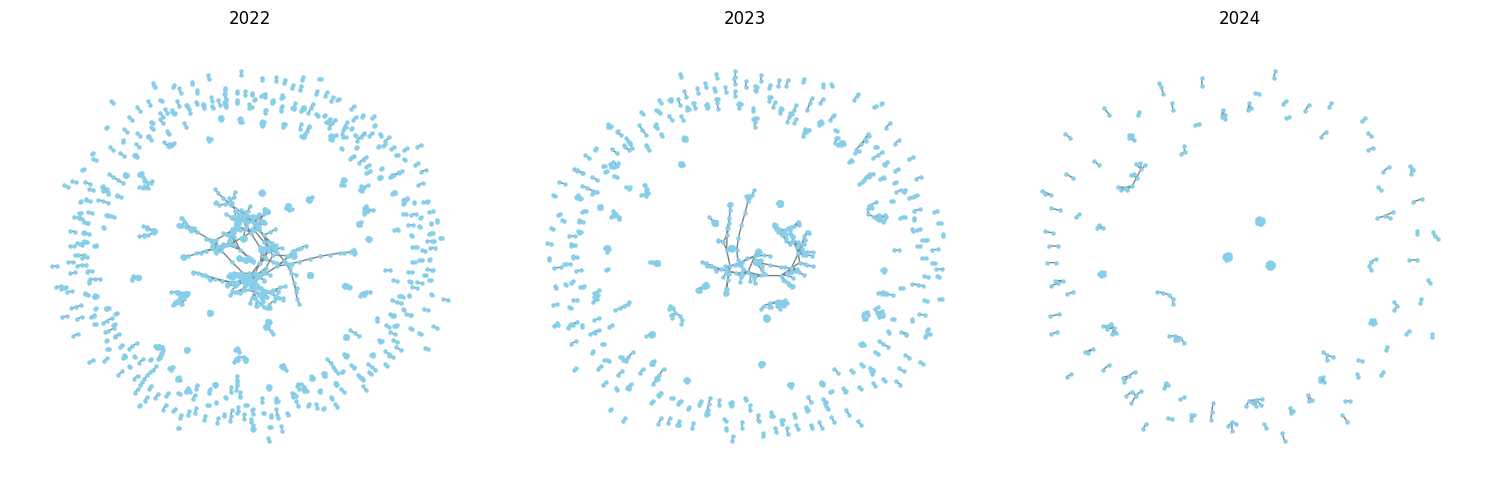

In [11]:
ga.plot_graphs_from_dict(boardex_interlock_adj_dict)

Given that we have seen relevant clustering structure in these communities, we will try a few community detection approaches to see what meaningful clusters can be found. First we use the Louvain community detection algorithm on graphs across all 3 years. This is useful, since it is computationally effcient and arranges communities where internal connectivity is stronger than those outside. I want to try this, as the full dataset could contain a very number of nodes. We can see that the with this naive approach, due to the sparsity of the graph, we get many small communities instead of larger communities (uncomment below). 

In [12]:
# ga.plot_louvain_communities_from_dict(boardex_interlock_adj_dict) # uncemment to see

Another approach is to use decomposition approaches for example with the SVD or eigen-decomposition of the Laplacian of these graph adjacency matrices. Here we apply the spectral clustering, which first perfoms eigen-decomposition, into a latent spaces based on the eigenvectors of the h highest eigenvalues, and then perform clustering using k-means clustering. Here this is done using the default `SpectralClustering` class from sklearn. Given that we've previously seen a global centralised grouping and more less connected groups, I set the number of clusters to 2, to see whether we can recreate these clusters.

With the visualisation below, it does not seem to be the case (in 2022 and 2023), with the main highly connected cluster grouped together with the many smaller clusters. As seen with the graph density statistics, we can see that these graphs are extremely sparse, in which simple de-composition methods like SVD would not work very well. Hence the algorithm is clustering all sparse components together with everything else. This suggests that we need to create a less sparse graph, perhaps by not considering a bridging effect graph, but a simple interlocking by considering only a single common company between 2 directors.

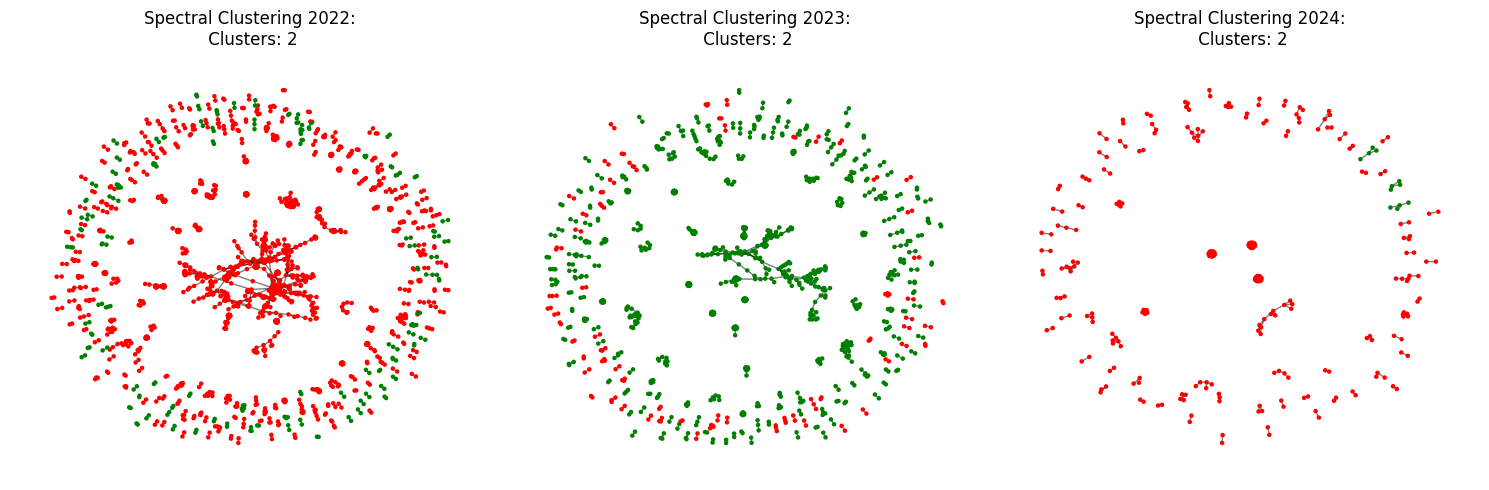

In [13]:
# visualise the graph densities in the above, for overview of content
ga.plot_spectral_clustering_from_dict(boardex_interlock_adj_dict, n_clusters=2, colour_map = ['red', 'green', 'blue', "orange", "yellow"])

Given that we see that there is incomplete data for 2024, I have decided for the final model, to only include relevant graph data for 2022 and 2023, and also combine the data I have available for board-interlocking graphs with the annual reports data, meaningful features for the final regression models to evaluate company performance on US pharma companies.

### 3. Analysis of Text - Annual Report for Decisioning

In this section, we look at the annual report information content for the related US companies. For these reports, we will focus on the business overview section of the annual report (section 1) as well as the risk overview section (section 1A). This will give us insight on decisioning focus of the directors, based on their business operations and risk focus (orientation) respectively. Here we look at the reports which were filed in 2022, 2023, and 2024, reflecting the annual reports for the financial year 2021, 2022, and 2023 respectively Overall, we will analyse 2,373 annual reports with a focus on these 2 sections.

##### a. Topic Modelling with LDA Analysis

First we analyse the information content of the annual report and business overview text by topic modelling using the standard Latent Dirichlet Allocation (LDA) model with a pre-determined number of topics. We focus on the topic modelling focussing on the risk overview section of all the annual reports we have. This will allow us to understand which risks the company directors are focussed on as part of their business management.

In [14]:
sec_10k_df = pd.read_json("raw_data/all_companies_report_annual_report_text_2022_2024.json")

In [15]:
# sec_10k_df.head()[["companyName","periodOfReport","Text_1", "Text_1A"]]

In [16]:
sec_10k_df.shape

(2373, 21)

As part of training the LDA model, we first preprocess the text by removing stop words, and tokenising the each word using the Porter's stemmer to reduce all words into their root form (see commented out code). As this can take a while, we simply load the pre-processed file below with the cleaned text. This is then used to create a optimised dictionary and corpus to train and run our LDA model using the `gensim` package.

In [17]:
# take 6 minutes to run so skip this section
# sec_10k_df = ta.clean_tokenise_risk_assessment_txt(sec_10k_df)

In [18]:
docs_tok = pd.read_json("processed_data/all_companies_metadata_2022_2024_text_1A_cleaned.json")["Text_1A_data_cleaned"]
common_dictionary = Dictionary(docs_tok)
common_corpus = [common_dictionary.doc2bow(text) for text in docs_tok]

For the standard LDA we're implementing, we need to select the optimal number of topics here for our model. For choosing topics we use the frequentist approach to select the optimal number of topics, the performance metric used is often either the perplexity score like in [Blei et al (2003)](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) or coherence score (as shown by [Stackoverflow](https://stackoverflow.com/questions/17421887/how-to-determine-the-number-of-topics-for-lda) and [Mathworks](https://uk.mathworks.com/help/textanalytics/ug/choose-number-of-topics-for-LDA-model.html)). We choose to select the optimal topics by coherence score (uncomment code below). This gave us a optimal number of 4 topics for our analysis (exploring the number of topics between 2 to 6), to train our LDA model. Given training and hyperparameter tuning can take a long time, we load the trained model here from `lda_model/risk_lda_model.gensim`.

In [19]:
# optimal_la_model, optimal_num_topics = ta.select_optimal_LDA_topic_number(docs_tok, common_corpus, common_dictionary, min_topics = 2, max_topics = 8)
# optimal_la_model.save("lda_mode.gensim")

In [20]:
optimal_num_topics = 4
lda_model = LdaMulticore.load("lda_model/risk_lda_model.gensim")

Next, we then analyse the information content of these topics for the risk overview by looking the topic-word distribution of each topic, generated from 2373 annual reports. This is done by analysing the most important words by weight. We can see below the weights of the most important words in of the 4 selected topics.

Here we see that all 4 topics have some degree of overlap. For example, they all relate to the product delivery as that is the most important words in each topic, and the word "may" suggesting that the main risk in pharmeceutical companies is chance of not delivering. Topic 0 seems to be focussed on risks relating clincal trials with patients. Topic 1, seems to be focussed on the approval risk of clinical trials. Topic 2 seems to relate to the risks on the variety of developed products themselves, and Topic 3 relate to the reception and market performance on the developed products for these pharmceutical companies. These make sense since the main focus on pharmaceutical companies is on research and development of new drugs as new products.

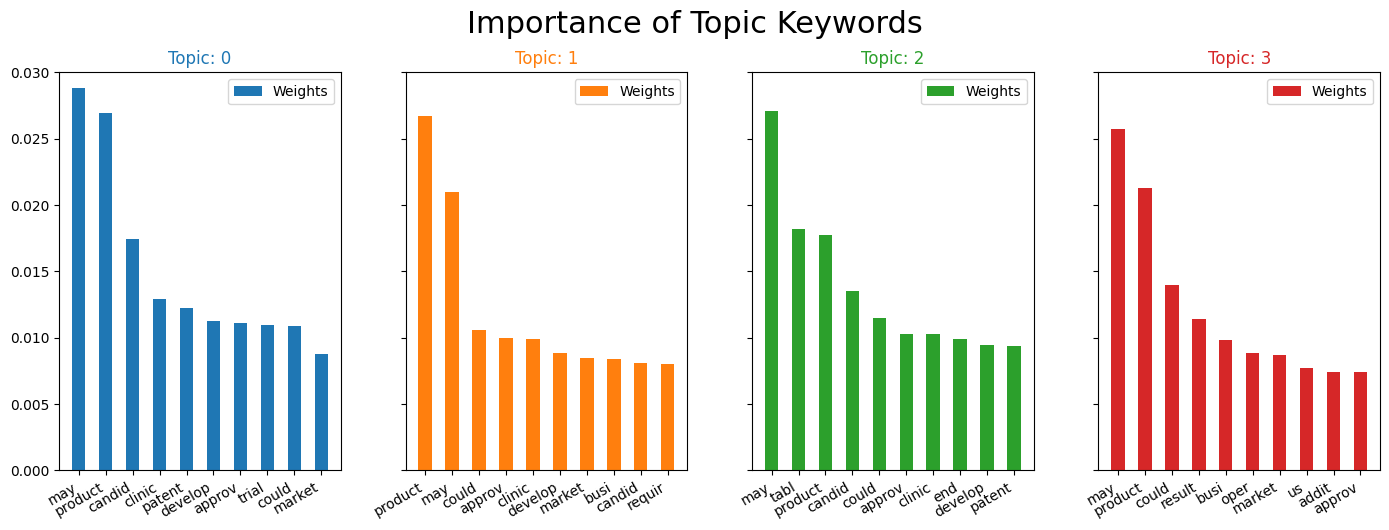

In [21]:
ta.plot_topic_compositions(lda_model, common_dictionary, figsize = (14,5))

Given the interpretation of our topics, we look at the dominant topic of each document and see whether there is meaningful clustering of these documents in these clusters. We do this using T-SNE, super-imposing the document topic matrix into a 2D plane, and displaying the dominant topic for each document.

We can see that there is a good degree of cluster separation in the 4 clusters. This therefore shows that the document-topic distribution for each topic is meaningful, we can therefore use these for the panel regression to analyse the effect on corporate governance. In particular, we will use these dominant topics for each document (one with the highest weight) as features for each document in the panel regression.

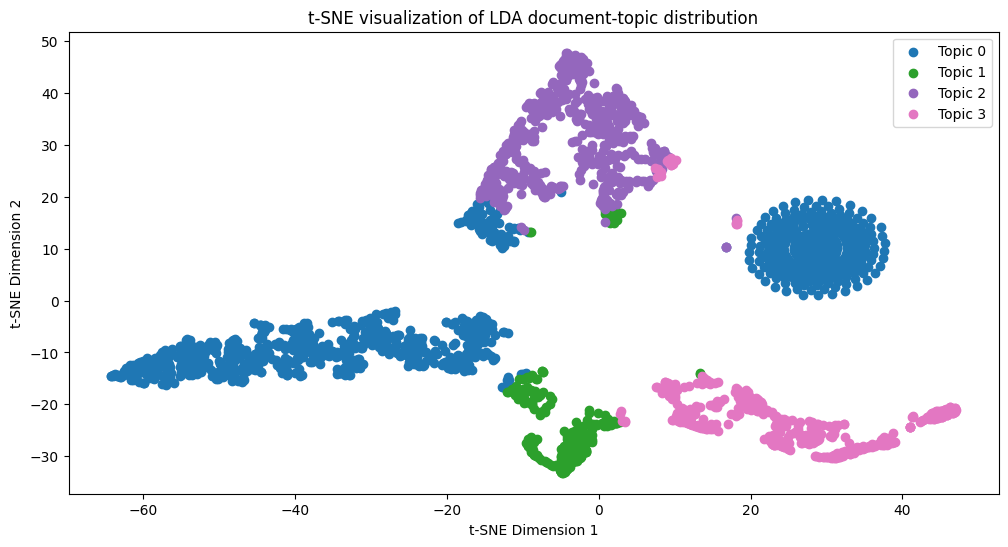

In [22]:
ta.plot_dominant_topic_distributions(lda_model, common_corpus)

In [23]:
sec_10k_df["topic_distribution"] = [lda_model.get_document_topics(bow, minimum_probability=0) for bow in common_corpus]

##### b. Sentiment Analysis with FinBert Transformer

In addition, the sentiment of the annual reports are useful. Hence we next evaluate the sentiments of the text over time, in particular we will focus on the business overview section of the annual report (section 1) as well as the risk overview section (section 1A). This gives us an overview of what the managers of outlook market sentiment on the pharmaceutical industry they operate in. In order to measure the sentiment of the text we use the FinBERT Transformer, which is a deep learning Transformer model which is trained to output text sentiment specifically on financial text ([paper](https://onlinelibrary.wiley.com/doi/full/10.1111/1911-3846.12832)). Specifically this paper by Huang et al (2023), shows that the model is specifically pre-trained on same financial texts from Edgar from the base BERT model. Therefore the sentiment predictions are likely to be highly accurate. Moreover, I have manually reviewed a few documents to test their accuracy.

In [24]:
sec_10k_df = pd.read_json("processed_data/all_companies_report_annual_report_text_2022_2024_with_sentiments_topics.json")
sec_10k_df["report_year"] = pd.to_datetime(sec_10k_df["periodOfReport"]).apply(lambda x : x.year)

In [25]:
sec_10k_df[["cik", "report_year", "risk_sentiment", "business_overview_sentiment"]].head(2)

,cik,report_year,risk_sentiment,business_overview_sentiment
0,318154,2023,0,-1
1,318154,2022,-1,-1


In the below we look at the text sentiments for the years 2021, 2022 and 2023 for the business risk sentiment (section 1A) and business overview (section 1). The visualisations below provide a count of documents by sentiment where -1 is negative, 0 neutral and 1 positive.

In [26]:
# ta.plot_annual_report_sentiments(sec_10k_df, 'risk_sentiment', [2021, 2022, 2023] )

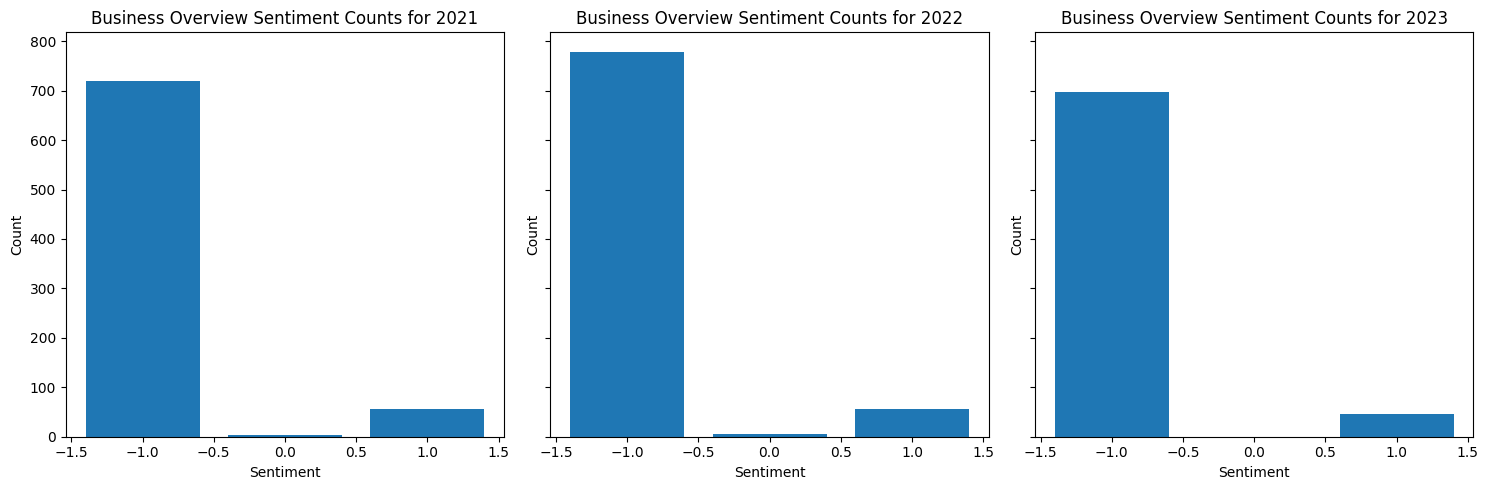

In [27]:
ta.plot_annual_report_sentiments(sec_10k_df, 'business_overview_sentiment', [2021, 2022, 2023] )

In the above analysis of the sentiments, we can see that in the period between 2021 to 2023, the risk overview is balanced between negative and neutral over the 3 years (uncomment). This makes sense since risk overviews tend to contain potential outcomes that directors want to avoid. What's more interesting is the business overview section sentiments, which contain documents that are pre-dominantly negative. This therefore suggests that directors have a predominantly negative outlook on the pharmaceutical industry they operate in.

### 4. Combining the datasets together

Here we combine the information from the graph statistics, annual report text topic distributions and sentiments and financial data on pharmaceutical companies into a single table/dataframe to run panel regression. In particular we obtain financial data extracted from Compustat, which provides extensive financial data for public companies. This dataset includes key performance indicators such as revenue, profitability, R&D expenditure, and market capitalisation. To combine the annual reports to other datasets, we need to match the `CIK` security id assigned to each company in the SEC database to the common `gvkey` company id that we can match with Boardex and Compustat, this is done with the `sec_gvkey_cik_us_pharma_2022_2024.csv` dataset file below.

In [28]:
# get the annual report compustat keys # first step
ar_key_df = pd.read_csv("raw_data/sec_gvkey_cik_us_pharma_2022_2024.csv", index_col = 0)
ar_key_df[["gvkey", "cik"]].head(2)

,gvkey,cik
0,1602,318154.0
1,1979,9326.0


Next we load the Compustat dataset, which contains financial and market data covering publicly traded companies in more than 80 countries, to get the financial metrics we need on these companies of interest to study their company performance, with respect to corporate governance.

In [29]:
# load the compustat data
compustat_data_df = pd.read_csv("raw_data/compustat_pharma_2021_2024_manual.csv", low_memory=False)

In [30]:
# use this final data to load everything so it is fine!! final merged data is everything
final_merged_data_df = ra.get_combined_financial_graph_ar_dataset(ar_key_df, sec_10k_df, 
                                                boardex_graph_stats_df, compustat_data_df)

final_merged_data_df.shape

(1136, 991)

### 5. Initial Regression model on Corporate Governance with Company Performance

As part of my final analysis, I will create a naive regression model to analyse factors driving company performance in bio-pharmaceutical firms using panel regression analysis utilizing Random-effects Generalized Least Squares (GLS). To simplify the analysis, this will be done using Stata. Moreover I assume that Stata is the Standard Edition and installed in `/usr/local/stata18` folder. Otherwise the file path of the installed Stata programme can  can be edited in the `stata_setup.config` at the very top of the notebook file. The corresponding documentation can found on the [Stata python docs](https://www.stata.com/python/pystata18/stata.html#pystata.stata.run).

In the lines below, we do the further required data preprocessing in Stata to convert the data into panel data and run the two panel regression models. There are a few limitations to the data, there are duplicates in terms of the annual reports to companies, this is perhaps due to companies being merged or acquired in later years. We therefore need to drop duplicates by company id (`gvkey`) and financial year (`fyear`). This leaves us only around 900 companies (observations) to analyse over 2 years (2022 and 2023). Also only a subset of the variables are used for these panel models, out of all available variables for our board interlocking graph, annual report features, and financial metrics.

In [31]:
ra.run_regression_preprocess(final_merged_data_df, stata)

In [32]:
stata.run("xtreg epsfi sale local_clustering_coef degree_centrality betweenness_centrality graph_density risk_sentiment business_overview_sentiment risktopic1 risktopic2 risktopic3 , re")


Random-effects GLS regression                   Number of obs     =        949
Group variable: gvkey                           Number of groups  =        557

R-squared:                                      Obs per group:
     Within  = 0.0363                                         min =          1
     Between = 0.0236                                         avg =        1.7
     Overall = 0.0327                                         max =          2

                                                Wald chi2(10)     =      28.44
corr(u_i, X) = 0 (assumed)                      Prob > chi2       =     0.0015

------------------------------------------------------------------------------
       epsfi | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
        sale |   .0001764   .0000684     2.58   0.010     .0000425    .0003104
local_clus~f |   .3180965   1.085348     0.29   0.769    -1.8091

##### Naive Model: Measuring Firm Performance by EPS

In the above model, which has an R-squared value of 0.033, assesses firm performance using "earnings per share" (`epsfi`) as the dependent variable. The analysis indicates a positive correlation between firm performance and the firm's sales (`sale`), which aligns with conventional business theory suggesting that higher sales volumes typically bolster profitability, and somewhat significant with 1% level of significance).

However, an unexpected result emerges from the variable representing the graph density of board interlocks (`graph_density`). Here, we observe a negative association with firm performance, implying potential drawbacks of tightly knit governance networks. While such interlocks might facilitate enhanced information exchange and resource sharing, they may also introduce conservatism and stifle innovation by overly solidifying existing networks and practices. This dynamic could potentially hinder a firm's adaptivity, detrimentally affecting performance. Moverover, we see here that the second risk topic (`risktopic1`) is also signficant and has a negative effect with respect to sales, which makes sense, as potential market risks, which the directors want to avoid would have a negative detriment on sales, especially since this risk topic focusses on clinical trials failing. These results requires further exploration into whether there exists an inverted U-shaped relationship between the density of board interlocks and firm performance. Such as relationship can suggest that a moderate level of interlocks could be optimal, providing benefits without the drawbacks of excessive interconnection.


### 6. Research Directions and Next steps

We have found some interesting initial findings from the initial EDA on board interlocks from graph data, decisioning topics from annual reports, as factors which impacts firm performance. There are a few limitations to the approach above. For instance, I have only included 2 years worth of data in the panel regression, this could potentially raise doubt on the validity of the results presented above. The next steps will focus on enhancing the robustness of the findings. This allow for further contributions to the research on corporate governance, strategic decision-making, and innovation within the biopharmaceutical industry.

First, further research will delve into the specific qualities of board interlocks, such as the diversity of expertise and industry representation among interlocked boards, to understand how these attributes influence the decision-making and innovation capacity of firms. Second, further analysis can done on managerial focus by analysing their attitudes on industry sentiment and risk focus/orientation, in corporate communication documents. More advanced NLP and topic modelling techniques, augmented by Bayesian methods, will provide deeper insights into how these factors correlate with strategic choices and performance outcomes. In addition applying Bayesian analysis overall into analysis of graphs and machine learning will refine the understanding of complex interdependencies and predictive capabilities concerning firm performance.